# Predicting Stock Prices using LSTM

## Model Analysis

The proposed **LSTM** model highlights both the promise and pitfalls of applying deep learning to financial forecasting. Below is a concise overview of the key challenges discovered and the strategies recommended for improvement.

---

### Core Challenges

1. **Illusion of Accuracy (Bad Target Variable)**
   - *Issue*: Initial model predicted the **next‑candle close price**, which is almost always ≈ current price.  
   - *Effect*: Near‑perfect charts but **no real trading edge**—the model simply mirrors price inertia.

2. **Difficulty Forecasting Price Movement**
   - *Issue*: When switched to predicting **price change** (direction + magnitude), accuracy collapsed.  
   - *Effect*: Exposed the model’s inability to capture the **stochastic** nature of markets.

---

### Improvement Roadmap

| Area | Action | Rationale |
|------|--------|-----------|
| **Target Definition** | Predict *price movement* (Δ close) instead of raw price | Provides a realistic, tradable objective |
| **Feature Engineering** | - Add advanced technical indicators<br>- Incorporate alternative data (news, sentiment) | Enriches signal space beyond OHLC |
| **Model Architecture** | Tune LSTM depth, units, dropout | Better captures temporal patterns |
| **Look‑back Window** | Optimize sequence length | Too short ⇒ misses trends; too long ⇒ noise |
| **Hyperparameter Tuning** | Grid/Random/Bayesian search on LR, batch size, etc. | Finds the sweet spot for learning |

---

### Takeaway

Perfect prediction is unattainable, but **honest evaluation metrics** combined with systematic feature and hyperparameter tuning can turn the LSTM into a **practical forecasting tool**—one that focuses on meaningful market movements rather than illusory accuracy.

---

The visual demonstrates that the LSTM model can identify general trends in the data, but it is not effective at predicting the precise, volatile, and stochastic nature of stock price movements, particularly when the target variable is price change.   
In depth analysis is provided at the end!
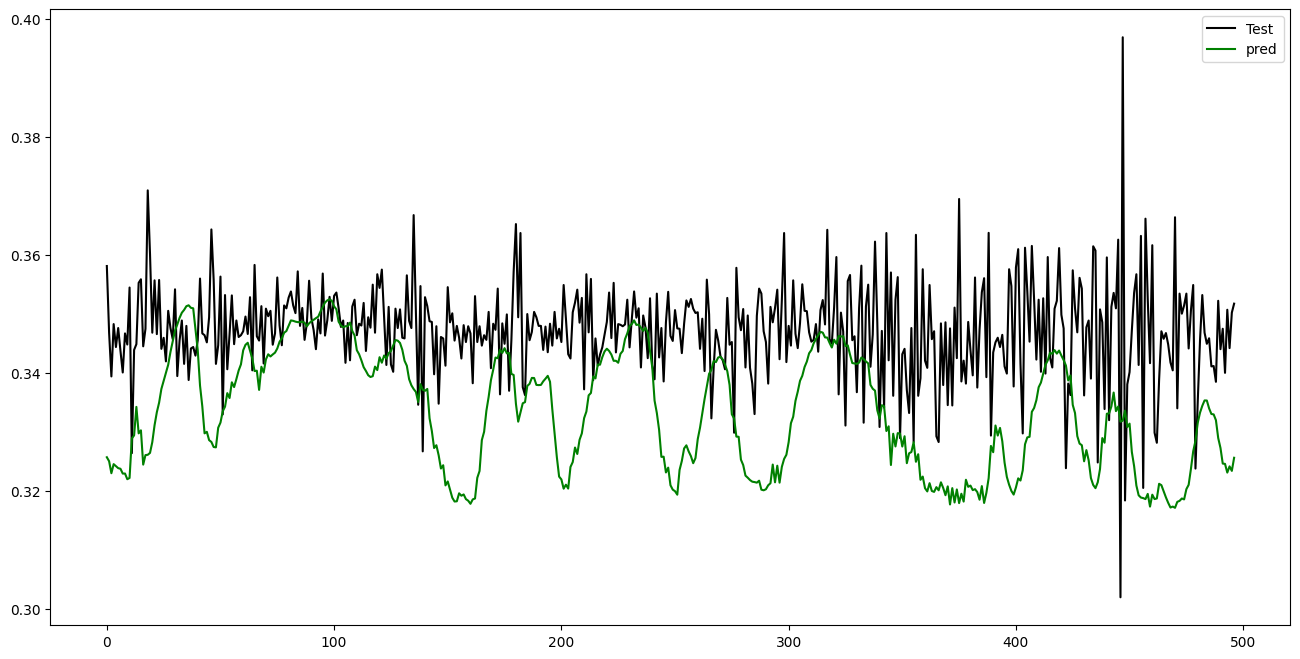

In [1]:
# Requirements
# %pip install numpy pandas matplotlib 
# %pip install scikit-learn tensorflow
# %pip install --upgrade keras

In [2]:
import sys, pathlib
# Go up to project root, then into Main/
main_path = pathlib.Path("..", "Main").resolve()
sys.path.append(str(main_path))

In [26]:
# Loading the data
from data_collection import StockDataCollector
from data_cleaning import StockDataCleaner

# 1. Collect data
collector = StockDataCollector(historical_data_path='../Datasets/Historical Data') # specify the path of dataset dir
collector.collect_data()

# 2. Clean data
cleaner = StockDataCleaner()
cleaned_data = cleaner.clean_all(collector)

Looking for data in: c:\Users\LENOVO\Documents\GISMA\Data Mining\Stock-Predictions\Datasets\Historical Data
Successfully loaded 5 tickers


In [34]:
# Using META Historical Data
META = cleaned_data["META"]
META

,Date,Close,Volume,Open,High,Low
0,2025-06-13,682.870,9274441,687.950,694.5700,681.01
1,2025-06-12,693.360,7322730,693.300,695.3800,687.00
2,2025-06-11,694.140,9582508,703.705,708.8707,691.99
3,2025-06-10,702.400,10850150,701.345,703.2300,691.56
4,2025-06-09,694.060,12773220,698.460,705.1900,693.94
...,...,...,...,...,...,...
2511,2015-06-19,82.510,23337800,82.830,82.9800,82.12
2512,2015-06-18,82.905,26726860,81.640,83.1900,81.57
2513,2015-06-17,81.790,18326140,81.760,82.2200,81.34
2514,2015-06-16,81.060,13673040,80.820,81.5100,80.45


In [35]:
# %pip install ta
from technical_indicators import TechnicalIndicators
import pandas as pd
import numpy as np

# 1. Calculate all technical indicators
aapl_with_indicators = TechnicalIndicators.calculate_all_indicators(META)

# 2. Target variables - Checking the difference between price for current open and the future close price
aapl_with_indicators['Target'] = aapl_with_indicators['Close'] - aapl_with_indicators['Open']
aapl_with_indicators['Target'] = aapl_with_indicators['Target'].shift(-1)


# 3. Final dataset after cleaning
data = aapl_with_indicators.dropna().reset_index(drop=True)

# 4. Selecting Technical Indicators 
keep_columns = [
    'Open', 'High', 'Low', 'Close',  # Price data
    'SMA_50', 'SMA_200', 'EMA_12', 'EMA_26',  # From TechnicalIndicators
    'MACD', 'MACD_Hist',                  # MACD indicators
    'Stoch_%K', 'Stoch_%D',               # Stochastic
    'BB_Upper', 'BB_Lower', 'ATR',        # Volatility
    'Target'  # Targets
]

data = data[keep_columns]

# 5. Verify the data
print("Final dataset shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nSample data:")
print(data.head(5))

Final dataset shape: (2515, 16)
Columns: ['Open', 'High', 'Low', 'Close', 'SMA_50', 'SMA_200', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Hist', 'Stoch_%K', 'Stoch_%D', 'BB_Upper', 'BB_Lower', 'ATR', 'Target']

Sample data:
      Open      High     Low   Close      SMA_50     SMA_200      EMA_12  \
0  687.950  694.5700  681.01  682.87  682.870000  682.870000  682.870000   
1  693.300  695.3800  687.00  693.36  688.115000  688.115000  684.483846   
2  703.705  708.8707  691.99  694.14  690.123333  690.123333  685.969408   
3  701.345  703.2300  691.56  702.40  693.192500  693.192500  688.497192   
4  698.460  705.1900  693.94  694.06  693.366000  693.366000  689.353008   

       EMA_26      MACD  MACD_Hist   Stoch_%K   Stoch_%D    BB_Upper  \
0  682.870000  0.000000   0.000000  13.716814  13.716814  682.870000   
1  683.647037  0.836809   0.669447  85.942937  49.829875  698.605000   
2  684.424294  1.545115   1.102202  47.127316  48.929022  700.400847   
3  685.755827  2.741364   1.838761  76.7

In [36]:
# Making a decent dataset with dataframe

data_set = data.iloc[:, :]
data_set.head(20)

,Open,High,Low,Close,SMA_50,SMA_200,EMA_12,EMA_26,MACD,MACD_Hist,Stoch_%K,Stoch_%D,BB_Upper,BB_Lower,ATR,Target
0,687.950,694.5700,681.0100,682.87,682.870000,682.870000,682.870000,682.870000,0.000000,0.000000,13.716814,13.716814,682.870000,682.870000,0.000000,0.060
1,693.300,695.3800,687.0000,693.36,688.115000,688.115000,684.483846,683.647037,0.836809,0.669447,85.942937,49.829875,698.605000,677.625000,0.000000,-9.565
2,703.705,708.8707,691.9900,694.14,690.123333,690.123333,685.969408,684.424294,1.545115,1.102202,47.127316,48.929022,700.400847,679.845820,0.000000,1.055
3,701.345,703.2300,691.5600,702.40,693.192500,693.192500,688.497192,685.755827,2.741364,1.838761,76.774812,69.948355,707.058209,679.326791,0.000000,-4.400
4,698.460,705.1900,693.9400,694.06,693.366000,693.366000,689.353008,686.370951,2.982057,1.663563,46.840173,56.914100,705.787270,680.944730,0.000000,1.540
5,696.170,702.8060,691.8700,697.71,694.090000,694.090000,690.638699,687.210881,3.427819,1.687460,59.941064,61.185349,705.882235,682.297765,0.000000,-7.040
6,691.660,694.3800,682.2500,684.62,692.737143,692.737143,689.712746,687.018964,2.693782,0.762739,12.957320,39.912852,705.508865,679.965421,0.000000,18.630
7,669.320,689.0000,668.5700,687.95,692.138750,692.138750,689.441554,687.087929,2.353625,0.338065,48.088495,40.328959,704.498092,679.779408,0.000000,-4.595
8,671.445,675.5800,665.0300,666.85,689.328889,689.328889,685.965930,685.588823,0.377107,-1.310762,4.151394,21.732403,709.037541,669.620237,0.000000,26.510
9,644.390,673.2600,644.2616,670.90,687.486000,687.486000,683.648095,684.500762,-0.852668,-2.032429,41.230105,31.156665,709.208166,665.763834,0.000000,4.990


In [37]:
# Dataset Information 
print(f'New Dataset Shape: {data_set.shape} -> New Dataset Type: {type(data_set)}')
print(f'Previous Dataset Shape: {data.shape} -> Previous Dataset Type: {type(data)}')

New Dataset Shape: (2515, 16) -> New Dataset Type: <class 'pandas.core.frame.DataFrame'>
Previous Dataset Shape: (2515, 16) -> Previous Dataset Type: <class 'pandas.core.frame.DataFrame'>


In [38]:
# Applying scaler to our new data because we are using Neural Networks; so the data should be between 0 and 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.92708318 0.92972399 0.93174933 ... 1.         0.         0.30062669]
 [0.93520191 0.93095238 0.94091368 ... 0.9913578  0.         0.21257033]
 [0.9509917  0.95141143 0.94854809 ... 0.99501705 0.         0.30972966]
 ...
 [0.00699577 0.00254777 0.01464153 ... 0.01129706 0.06922038 0.30035223]
 [0.00717787 0.00107674 0.01428965 ... 0.01013792 0.06732053 0.30227346]
 [0.0057514  0.         0.012928   ... 0.0087726  0.06511868 0.30154156]]


In [39]:
# Input data (X)
data_set.iloc[:, :15].head()

,Open,High,Low,Close,SMA_50,SMA_200,EMA_12,EMA_26,MACD,MACD_Hist,Stoch_%K,Stoch_%D,BB_Upper,BB_Lower,ATR
0,687.950,694.5700,681.01,682.87,682.870000,682.870000,682.870000,682.870000,0.000000,0.000000,13.716814,13.716814,682.870000,682.870000,0.0
1,693.300,695.3800,687.00,693.36,688.115000,688.115000,684.483846,683.647037,0.836809,0.669447,85.942937,49.829875,698.605000,677.625000,0.0
2,703.705,708.8707,691.99,694.14,690.123333,690.123333,685.969408,684.424294,1.545115,1.102202,47.127316,48.929022,700.400847,679.845820,0.0
3,701.345,703.2300,691.56,702.40,693.192500,693.192500,688.497192,685.755827,2.741364,1.838761,76.774812,69.948355,707.058209,679.326791,0.0
4,698.460,705.1900,693.94,694.06,693.366000,693.366000,689.353008,686.370951,2.982057,1.663563,46.840173,56.914100,705.787270,680.944730,0.0


In [40]:
# Output (y)
"""Predicting the Target value which is the difference between price for current open and the future close price"""
data_set['Target'].head()

0    0.060
1   -9.565
2    1.055
3   -4.400
4    1.540
Name: Target, dtype: float64

In [41]:
# Feeding input and output data
# Multiple feature from data provided to the model

X = []
# backcandles: number of days in past to predict the closing price of tomorrow's candle
backcandles = 30
print(data_set_scaled.shape[0])
for j in range(15):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

# Moving axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

# print(X) # 3 dim array 
print(X.shape)
# print(y) # 2 dim array
print(y.shape)

2515
(2485, 30, 15)
(2485, 1)


In [42]:
# Split data into train and test sets [80%(train) & 20%(test)]
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1988
(1988, 30, 15)
(497, 30, 15)
(1988, 1)
(497, 1)
[[0.39705411]
 [0.3772929 ]
 [0.24610036]
 ...
 [0.29870546]
 [0.29458854]
 [0.29998628]]


In [43]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

lstm_input = Input(shape=(backcandles, 15), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0214 - val_loss: 0.0011
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0032 - val_loss: 6.9560e-04
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0034 - val_loss: 4.1976e-04
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0033 - val_loss: 4.2147e-04
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0029 - val_loss: 4.2976e-04
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0034 - val_loss: 4.2558e-04
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0030 - val_loss: 5.9740e-04
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0029 - val_loss: 5.5708e-04
Epoch 9/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0036 - val_loss: 4.5050e-04
Epoch 10/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 11/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0033 - val_loss: 6.3707e-04
Epoch

In [15]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
[0.32574156] [0.35812288]
[0.3250685] [0.34683099]
[0.32303232] [0.33942448]
[0.32457274] [0.348288]
[0.32424167] [0.34440262]
[0.32389432] [0.3476202]
[0.32378802] [0.34373482]
[0.3229763] [0.34009228]
[0.32298225] [0.34670957]
[0.32201883] [0.34482759]


## 📉 Visual Analysis: Predicted vs. Actual Price Movement

The line plot compares **actual test data** ("Test") against **LSTM model predictions** ("pred") over ~500 data points, providing key visual evidence of the model’s performance in capturing market behavior.

---

### Plot Description

- **X-axis**: Data points (0 to ~500)
- **Y-axis**: Scaled target values (~0.30 to 0.40)

#### Black Line — “Test”
- Represents **true market price movements** in the test set.
- Highly **volatile** with rapid, sharp changes.
- A **notable spike** occurs between data points 420–430, likely an outlier or sudden market event.
- Reflects the **stochastic (random)** nature of financial markets.

#### Green Line — “pred”
- Represents **model-predicted values**.
- Appears **much smoother** than the Test line.
- Tracks the **general trend**, but **fails to capture sharp fluctuations**.
- Ignores the large spike around 420–430 entirely.

---

### Interpretation & Insights

| Observation | Insight |
|-------------|---------|
| ✅ General trend captured | Model can follow slow-moving, large-scale directional shifts. |
| ❌ Misses sharp moves | Indicates **limited responsiveness** to short-term volatility. |
| ❌ No reflection of outliers | Suggests the model is not robust to **sudden price shocks**. |

---

### Link to Model Limitations

This visualization **reinforces** the notebook analysis:

- **Illusion of Accuracy**: Smoother predictions give a **false sense of success** when using the wrong target (e.g., next-candle price).
- **Collapse on Real Tasks**: When challenged with forecasting **price movement**, the model underperforms, confirming it **struggles with noise and nonlinearity** inherent to market data.

---

### Conclusion

The model demonstrates **partial effectiveness**—capturing slow, general trends but missing the **true complexity** of market behavior. The gap between the black and green lines visually encapsulates the **intractability of predicting chaotic systems** using standard LSTM models without advanced feature sets or structural enhancements.


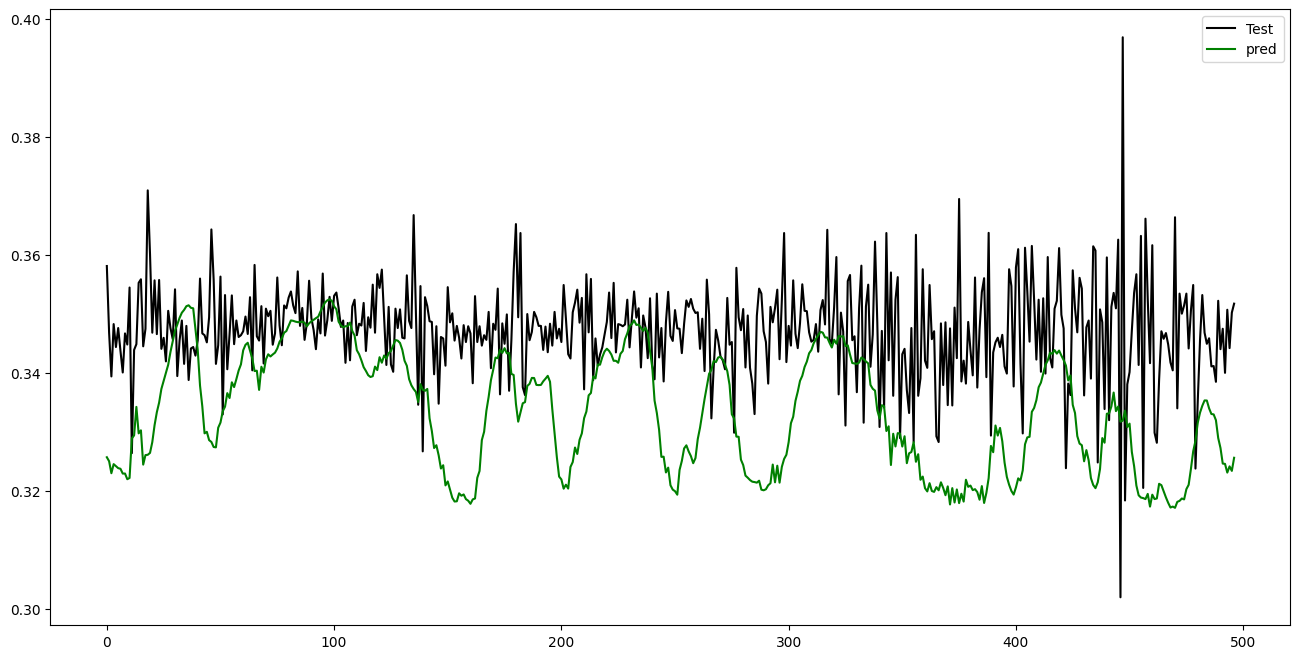

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()